##### Name:- Ruben Aayush
##### Student Number:- 25206670

In [6]:
import os
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# DL
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [7]:
train_path = "train"         
val_path = "validation"     
test_path = "test"         

### Step 1: Loading/combining data
#### We will load all csv's from each folder and combine them into 1 dataframe per split. Then we will convert timestamps to datetime. We are also sorting the rows by time.

In [8]:
def load_csv_folder(folder_path):
    """Loading all CSV files from a folder and merge into one DataFrame."""
    files = sorted(os.listdir(folder_path))
    dataframes = []

    for f in files:
        if f.endswith(".csv"):
            full_path = os.path.join(folder_path, f)
            df = pd.read_csv(full_path)
            dataframes.append(df)

    # Combining all files into one DataFrame
    return pd.concat(dataframes, ignore_index=True)

train_df = load_csv_folder(train_path)
val_df   = load_csv_folder(val_path)
test_df  = load_csv_folder(test_path)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (527040, 7)
Validation shape: (44640, 7)
Test shape: (128160, 7)


In [11]:
# Converting timestamps from ms to datetime for plotting
for df in [train_df, val_df, test_df]:
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

# Sorting by time
train_df = train_df.sort_values("open_time").reset_index(drop=True)
val_df   = val_df.sort_values("open_time").reset_index(drop=True)
test_df  = test_df.sort_values("open_time").reset_index(drop=True)

train_df.head()

,open_time,open,high,low,close,volume,close_time
0,2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999
1,2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999
2,2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999
3,2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999
4,2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999


### Step 2: Feature Engineering
#### In this step, we will create extra features from the raw price data. These include price changes, moving averages, RSI, MACD, volatility measures etc. This is the same feature set we used in Practical 3.

In [12]:
def create_features(df):
    df = df.copy()

    #Price based features
    df['price_range'] = df['high'] - df['low']
    df['price_change'] = df['close'] - df['open']
    df['price_change_pct'] = (df['price_change'] / df['open']) * 100

    #Moving averages
    df['ma_5'] = df['close'].rolling(window=5).mean()
    df['ma_10'] = df['close'].rolling(window=10).mean()
    df['ma_20'] = df['close'].rolling(window=20).mean()
    df['ma_50'] = df['close'].rolling(window=50).mean()

    df['ma_diff_5_10'] = df['ma_5'] - df['ma_10']
    df['ma_diff_10_20'] = df['ma_10'] - df['ma_20']

    #RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))

    #MACD
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp1 - exp2
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_diff'] = df['macd'] - df['macd_signal']

    #Volatility
    df['volatility_10'] = df['close'].rolling(window=10).std()
    df['volatility_20'] = df['close'].rolling(window=20).std()

    #Volume features
    df['volume_ma_5'] = df['volume'].rolling(window=5).mean()
    df['volume_ma_10'] = df['volume'].rolling(window=10).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma_10']

    #Momentum
    df['momentum_5'] = df['close'] - df['close'].shift(5)
    df['momentum_10'] = df['close'] - df['close'].shift(10)

    return df

In [13]:
# Applying fatures to all splits
train_df = create_features(train_df)

val_df = create_features(val_df)

test_df = create_features(test_df)

print("\nTotal features in training set:", train_df.shape[1])
train_df.head()


Total features in training set: 27


,open_time,open,high,low,close,volume,close_time,price_range,price_change,price_change_pct,...,macd,macd_signal,macd_diff,volatility_10,volatility_20,volume_ma_5,volume_ma_10,volume_ratio,momentum_5,momentum_10
0,2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999,46.2,17.9,0.042303,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999,21.3,18.5,0.043702,...,1.475783,0.295157,1.180627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999,21.2,9.8,0.023140,...,3.396972,0.915520,2.481453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999,45.7,45.7,0.107885,...,8.501072,2.432630,6.068442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999,31.5,31.4,0.074047,...,14.899999,4.926104,9.973895,NaN,NaN,344.842,NaN,NaN,NaN,NaN


### Step 3: Creating target column
#### Here we will create the target label using the rule - 
#### 1 (UP) if the close price 30 minutes ahead is higher than the current close.
#### 0 (DOWN) otherwise
#### We will apply this seperately to each split, and then remove NaN rows caused by rolling features.

In [15]:
def create_target(df, horizon=30):
    df = df.copy()
    
    # Price 30 minutes later
    df["future_close"] = df["close"].shift(-horizon)
    
    # Classification target
    df["target"] = (df["future_close"] > df["close"]).astype(int)
    
    return df


# Applying to each split
train_df = create_target(train_df)
val_df   = create_target(val_df)
test_df  = create_target(test_df)

# Removing rows with NaN
train_df = train_df.dropna().reset_index(drop=True)
val_df   = val_df.dropna().reset_index(drop=True)
test_df  = test_df.dropna().reset_index(drop=True)

print("Train shape after target creation:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

train_df["target"].value_counts(normalize=True)

Train shape after target creation: (526891, 29)
Validation shape: (44557, 29)
Test shape: (128081, 29)


target
1    0.505482
0    0.494518
Name: proportion, dtype: float64

### Step 4: Preparing final train/val/test sets
#### In this step, we will select the final feature columns. Then we create X and y for  training, validation, and testing. X represents the features for input, such as moving average, RSI, volatility etc and Y represents our target labels that contain UP(1) or DOWN(0). A StandardScaler is fitted on the training set only and applied to validation and test sets to avoid any data leakage.

In [16]:
# Columns to drop (non features)
cols_to_drop = [
    "open_time", "close_time",  # timestamps
    "open", "high", "low", "close", "volume",  # raw OHLCV (we use indicators instead)
    "future_close",            # created for target
    "target"                   # we will store separately
]

In [17]:
# Creating final feature list
feature_cols = [col for col in train_df.columns if col not in cols_to_drop]

print("Number of final features:", len(feature_cols))
print("Feature columns:", feature_cols)

Number of final features: 20
Feature columns: ['price_range', 'price_change', 'price_change_pct', 'ma_5', 'ma_10', 'ma_20', 'ma_50', 'ma_diff_5_10', 'ma_diff_10_20', 'rsi', 'macd', 'macd_signal', 'macd_diff', 'volatility_10', 'volatility_20', 'volume_ma_5', 'volume_ma_10', 'volume_ratio', 'momentum_5', 'momentum_10']


In [18]:
# Creating X and y for all datasets
X_train = train_df[feature_cols].values
y_train = train_df["target"].values

X_val = val_df[feature_cols].values
y_val = val_df["target"].values

X_test = test_df[feature_cols].values
y_test = test_df["target"].values

In [19]:
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [20]:
print("X_train_scaled:", X_train_scaled.shape)
print("X_val_scaled:", X_val_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)

X_train_scaled: (526891, 20)
X_val_scaled: (44557, 20)
X_test_scaled: (128081, 20)


### Step 5: Training model 1 (Random Forest Classifier)
#### We will create the model and train it on the training data. We will write a helper function and evaluate it on training, validation, and test sets using parameters like accuracy,precision, recall, and F1-score, along with a confusion matrix.

In [21]:
# creating model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

In [22]:
# model training
rf_model.fit(X_train_scaled, y_train)

print("Random Forest training complete.\n")

Random Forest training complete.



=== Random Forest Evaluation ===

Train Accuracy: 0.6437
Val Accuracy: 0.5233
Test Accuracy: 0.5127
Test Precision: 0.5125
Test Recall: 0.6031
Test F1: 0.5541


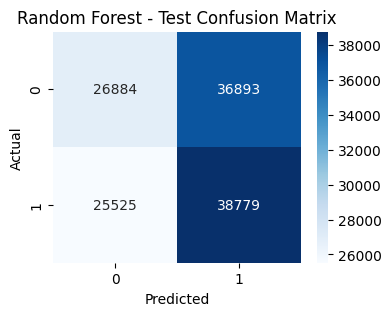

In [24]:
# helper function to evaluate the model on train/val/test
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name="Model"):
    print(f"=== {model_name} Evaluation ===\n")

    # Predictions
    pred_train = model.predict(X_train)
    pred_val   = model.predict(X_val)
    pred_test  = model.predict(X_test)

    # Metrics
    results = {
        "Train Accuracy": accuracy_score(y_train, pred_train),
        "Val Accuracy": accuracy_score(y_val, pred_val),
        "Test Accuracy": accuracy_score(y_test, pred_test),
        "Test Precision": precision_score(y_test, pred_test),
        "Test Recall": recall_score(y_test, pred_test),
        "Test F1": f1_score(y_test, pred_test)
    }
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

    # Plotting confusion matrix for the test set
    # This helps visualise how many UP/DOWN predictions the model got right or wrong.
    cm = confusion_matrix(y_test, pred_test)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return results


# Evaluation
rf_results = evaluate_model(
    rf_model,
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    model_name="Random Forest"
)

#### The confusion matrix shows that the Random Forest predicts the UP class more frequently, resulting in a higher recall for UP (0.603). Overall accuracy is around 51%, slightly better than chance. This makes Random Forest a useful baseline model.

### Step 6: Training model 2 (Extra Trees Classifier)
#### We will create the model and train it on training data. After training, we will evaluate it on the training, validation, and test sets using the same parameters as before, along with a confusion matrix for the test predictions.

In [25]:
# Creating the model
et_model = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

In [26]:
# Training
et_model.fit(X_train_scaled, y_train)

print("Extra Trees training complete.\n")

Extra Trees training complete.



=== Extra Trees Evaluation ===

Train Accuracy: 0.6016
Val Accuracy: 0.5214
Test Accuracy: 0.5096
Test Precision: 0.5072
Test Recall: 0.8133
Test F1: 0.6248


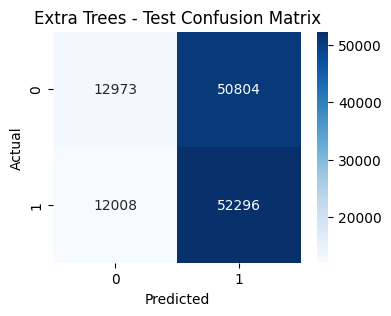

In [27]:
# Evaluating (reusing same helper function from Step 5)
et_results = evaluate_model(
    et_model,
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    model_name="Extra Trees"
)

#### Extra Trees shows strong recall for the UP class (0.81), meaning it captures upward moves well, but it predicts UP frequently, leading to false computes. Although accuracy is close to 50%, the F1-score improves compared to Random Forest, hence this a slightly better baseline model.

### Step 7: Training Model 3 (custom CNN+LSTM)
#### To build my custom deep learning model, I have chosen to combine 1 dimensional CNN layer with LSTM layer.The CNN learns short-term patterns inside each sequence of price indicators, and the LSTM tries to learn how these patterns are changing over time.
#### We will first convert the dataset into short time windows (sliding sequences), where each sequence contains features of 60 minutes. Then we train the CNN+LSTM model and evaluate it on the validation and test sets using accuracy, precision, recall, F1-score, and a confusion matrix.

In [28]:
# Converting data into sequences
# if seq_len = 60, each sample = 60 minutes of features.
seq_len = 60

def make_sequences(X, y, seq_len):
    X_seq = []
    y_seq = []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])  # label at the end of the window
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train, seq_len)
X_val_seq,   y_val_seq   = make_sequences(X_val_scaled,   y_val,   seq_len)
X_test_seq,  y_test_seq  = make_sequences(X_test_scaled,  y_test,  seq_len)

print("Train seq:", X_train_seq.shape, y_train_seq.shape)
print("Val seq:",   X_val_seq.shape,   y_val_seq.shape)
print("Test seq:",  X_test_seq.shape,  y_test_seq.shape)

Train seq: (526831, 60, 20) (526831,)
Val seq: (44497, 60, 20) (44497,)
Test seq: (128021, 60, 20) (128021,)


In [29]:
# PyTorch Dataset + dataloader
class PriceSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 256

train_dataset = PriceSequenceDataset(X_train_seq, y_train_seq)
val_dataset   = PriceSequenceDataset(X_val_seq,   y_val_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

In [30]:
# Defining the CNN + LSTM model
class CNNLSTMModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()

        # local pattern extraction
        self.conv1 = nn.Conv1d(
            in_channels=num_features,  # number of features
            out_channels=32,           # number of filters
            kernel_size=3
        )
        
        # reducing sequence length
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # LSTM to learn long-term patterns
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, batch_first=True)

        # reducing overfitting
        self.dropout = nn.Dropout(0.3)

        # Final connected layer
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        
        # CNN expects (batch, channels/features, seq_len)
        x = x.permute(0, 2, 1)

        x = torch.relu(self.conv1(x))
        x = self.pool1(x)

        # converting back for LSTM to (batch, seq_len, channels)
        x = x.permute(0, 2, 1)

        # runnning through LSTM
        x, _ = self.lstm(x)

        # fetching output at last timestep
        x = x[:, -1, :]

        x = self.dropout(x)
        x = self.fc(x)

        return torch.sigmoid(x).squeeze(1)

In [32]:
# Training model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_features = X_train_seq.shape[2]
model = CNNLSTMModel(num_features=num_features).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 3  
best_val_f1 = 0
best_state = None
for epoch in range(1, num_epochs + 1):
    # Training mode
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    train_loss = total_loss / len(train_dataset)
    # Validation
    model.eval()
    val_preds = []
    val_true = []
    val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(y_batch.cpu().numpy())

    val_loss /= len(val_dataset)
    val_preds = np.array(val_preds)
    val_true = np.array(val_true)
    val_labels = (val_preds >= 0.5).astype(int)
    val_f1 = f1_score(val_true, val_labels)

    print(f"Epoch {epoch}/{num_epochs}  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}  Val F1: {val_f1:.4f}")

    # Saving best model based on validation F1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict().copy()

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nLoaded best model with Val F1 = {best_val_f1:.4f}")

Using device: cpu
Epoch 1/3  Train Loss: 0.6916  Val Loss: 0.6919  Val F1: 0.5880
Epoch 2/3  Train Loss: 0.6906  Val Loss: 0.6931  Val F1: 0.6106
Epoch 3/3  Train Loss: 0.6897  Val Loss: 0.6973  Val F1: 0.6090

Loaded best model with Val F1 = 0.6106



CNN+LSTM (Train)
Accuracy:  0.5369
Precision: 0.5355
Recall:    0.6315
F1-score:  0.5796


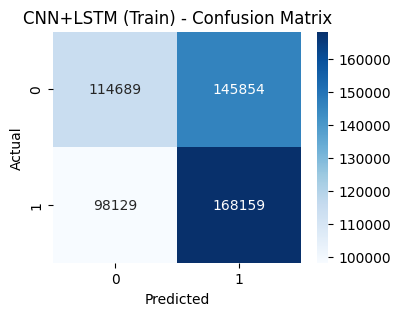


CNN+LSTM (Val)
Accuracy:  0.5109
Precision: 0.5081
Recall:    0.7600
F1-score:  0.6090


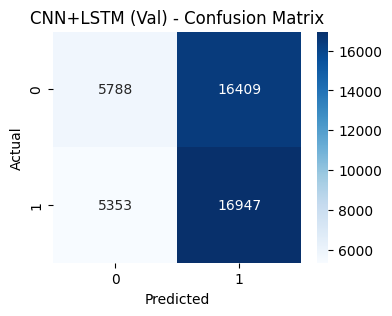


CNN+LSTM (Test)
Accuracy:  0.5050
Precision: 0.5047
Recall:    0.7501
F1-score:  0.6034


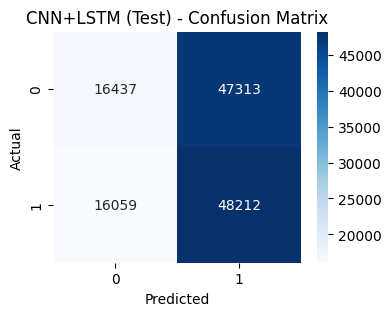

In [33]:
# Evaluation on train/val/test
def evaluate_dl(model, X_seq, y_seq, name):
    """Evaluating CNN+LSTM on a dataset."""
    model.eval()
    with torch.no_grad():
        X_t = torch.from_numpy(X_seq).float().to(device)
        probs = model(X_t).cpu().numpy()

    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(y_seq, preds)
    prec = precision_score(y_seq, preds)
    rec = recall_score(y_seq, preds)
    f1 = f1_score(y_seq, preds)

    print(f"\n{name}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    cm = confusion_matrix(y_seq, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

# Evaluation on all splits
dl_train_results = evaluate_dl(model, X_train_seq, y_train_seq, "CNN+LSTM (Train)")
dl_val_results   = evaluate_dl(model, X_val_seq,   y_val_seq,   "CNN+LSTM (Val)")
dl_test_results  = evaluate_dl(model, X_test_seq,  y_test_seq,  "CNN+LSTM (Test)")

#### Our findings ~
#### The CNN+LSTM model performs slightly better than the tree-based models in terms of F1-score, but the overall accuracy remains close to 50% across all splits. This is expected for short-term Bitcoin price prediction because the price movements are highly noisy and difficult to model. Similar to the ML models, the CNN+LSTM predicts the UP class much more frequently than the DOWN class. This leads to a high recall (0.75 on the test set), meaning the model is very good at detecting upward movements, but it also produces many false positives, which lowers its precision.

#### The confusion matrices confirms this pattern: most predictions fall into the UP class, and the model struggles to correctly identify DOWN movements. Even though accuracy is close to random, the improved F1-score (0.603 on the test set) shows that the deep learning model captures some temporal patterns that the Random Forest and Extra Trees models miss.

#### Overall, the CNN+LSTM shows a small improvement over traditional ML methods, but still represents the challenge of predicting BTC's short-term direction using only the historical price indicators.

### Step 8: Model Comparison/Visualization
#### After training all three models (Random Forest, Extra Trees, and the custom CNN+LSTM model), I combine their test set parameters into a single comparison table. I will also create bar charts to visually compare Accuracy, Precision, Recall, and F1-score across the models. This helps highlight which model performed best overall and how their behaviours differ.

In [34]:
# Combining all test results into a single df
comparison_data = {
    "Model": ["Random Forest", "Extra Trees", "CNN+LSTM"],
    "Accuracy": [
        rf_results["Test Accuracy"],
        et_results["Test Accuracy"],
        dl_test_results["Accuracy"]
    ],
    "Precision": [
        rf_results["Test Precision"],
        et_results["Test Precision"],
        dl_test_results["Precision"]
    ],
    "Recall": [
        rf_results["Test Recall"],
        et_results["Test Recall"],
        dl_test_results["Recall"]
    ],
    "F1-score": [
        rf_results["Test F1"],
        et_results["Test F1"],
        dl_test_results["F1"]
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Model,Accuracy,Precision,Recall,F1-score
0,Random Forest,0.512668,0.512462,0.603057,0.554081
1,Extra Trees,0.509592,0.507236,0.813262,0.624788
2,CNN+LSTM,0.504987,0.504706,0.750136,0.603419


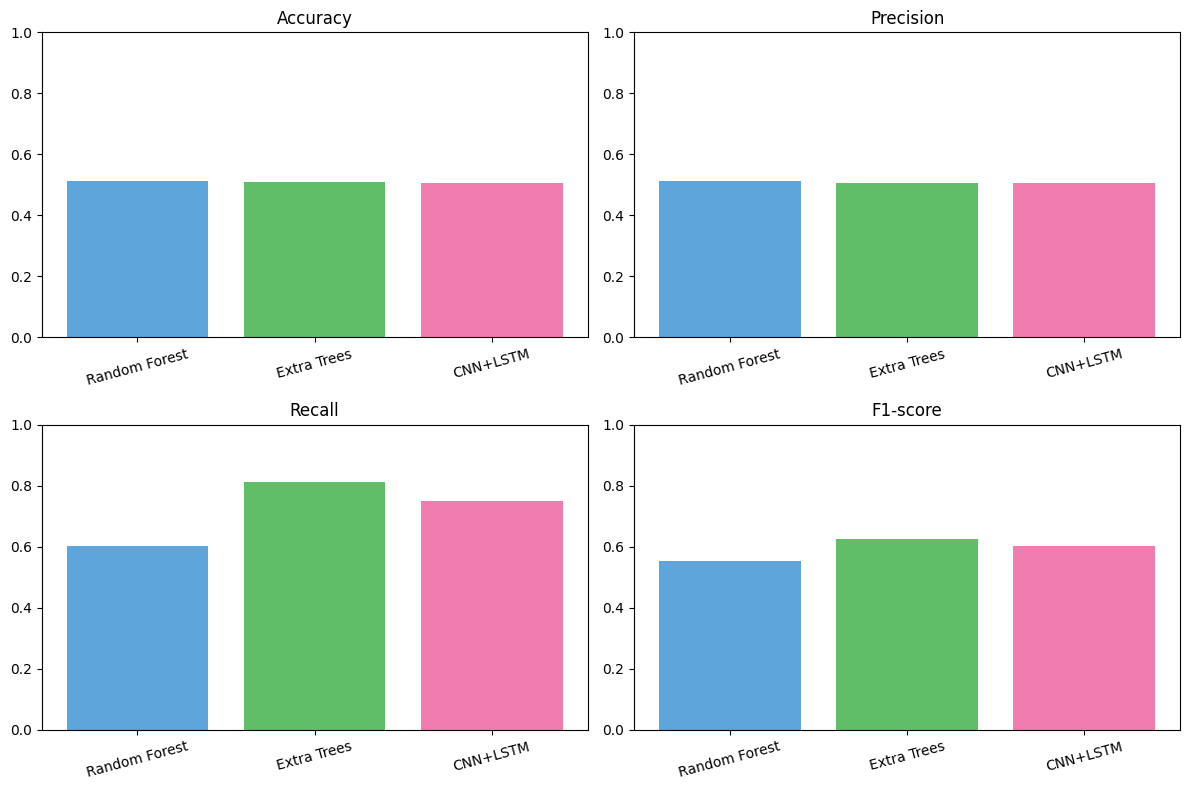

In [35]:
# Plot of comparison charts
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    plt.bar(comparison_df["Model"], comparison_df[metric], color=["#5DA5DA", "#60BD68", "#F17CB0"])
    plt.title(metric)
    plt.ylim(0, 1)   # all metrics between 0 and 1
    plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

#### The comparison charts show that all three models achieve very similar overall accuracy, staying close to 50%, which is expected for short-term bitcoin movement prediction. However, the models behave differently when looking at the other parameters. Random Forest is the most balanced model, with moderate precision, recall, and F1. Extra Trees achieves the highest recall, meaning it detects upward movements more frequently, but this also causes more lower precision. The CNN+LSTM model sits in the middle, with better recall than Random Forest but slightly lower than Extra Trees. Its F1-score is also competitive, showing that the deep learning model captures some patterns that the ML models might miss. Overall, all models achieve similar accuracy, but Extra Trees and CNN+LSTM provide stronger recall and F1 performance.